In [5]:
import pickle

from flask import Flask
from flask import request
from flask import jsonify

with open("../models/dv.bin", "rb") as file_in:
    dv = pickle.load(file_in)
    
with open("../models/lr.bin", "rb") as file_in:
    lr = pickle.load(file_in)

with open("../models/rf.bin", "rb") as file_in:
    rf = pickle.load(file_in)

with open("../models/xgb.bin", "rb") as file_in:
    xgb_model = pickle.load(file_in)
data = request.get_json()

# DictVectorizer
X_test = dv.transform([data])    

# Logistic Regression
lr_test_pred = lr.predict(X_test)[0]
# Random Forest
rf_test_pred = rf.predict(X_test)[0]
# XGBoost
features = dv.feature_names_
dtest = xgb.DMatrix(X_test[0].reshape(1, -1), feature_names=features)
y_pred = round(xgb_model.predict(dtest)[0])   

# Ensembled
lst = [lr_test_pred, rf_test_pred, y_pred]
final_pred = max(set(lst), key=lst.count) 

ValueError: node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv("../data/diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [11]:
def standardize_column_names(col_lst):
    return [col.lower().replace(' ', '_') for col in col_lst]

In [12]:
# Standardizing column names
df.columns = standardize_column_names(df.columns)

### EDA

In [14]:
print("Missing values in the DataFrame:")
df.isna().sum()

Missing values in the DataFrame:


gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
hba1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [15]:
# Seperate lists for numerical and categorical columns
num_col = [col for col in df.columns if is_numeric_dtype(df[col])]
cat_col = [col for col in df.columns if col not in num_col]

In [16]:
num_col

['age',
 'hypertension',
 'heart_disease',
 'bmi',
 'hba1c_level',
 'blood_glucose_level',
 'diabetes']

### Note: 
- Columns like diabetes, hypertension and heart_disease are categorical variable (dichotomous) already encoded as 0 (No) and 1 (Yes)

In [19]:
# Check for the unique values of the categorical variables

print("Unique Values in the categorical columns are:\n")
for col in cat_col:
    print(f"{col}: {df[col].nunique()} which are {df[col].unique()}")

Unique Values in the categorical columns are:

gender: 3 which are ['Female' 'Male' 'Other']
smoking_history: 6 which are ['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [28]:
# Check for duplicate rows
print(f"The number of duplicate rows: {df[df.duplicated()].shape[0]}")

The number of duplicate rows: 3854


In [30]:
df = df.drop_duplicates()
df.shape

(96146, 9)

### UNIVARIATE ANALYSIS

,age,hypertension,heart_disease,bmi,hba1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


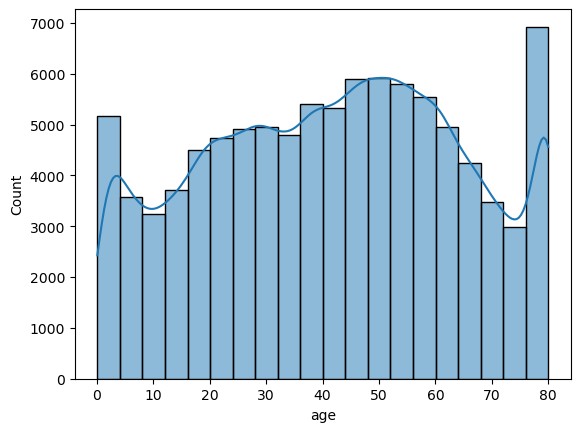

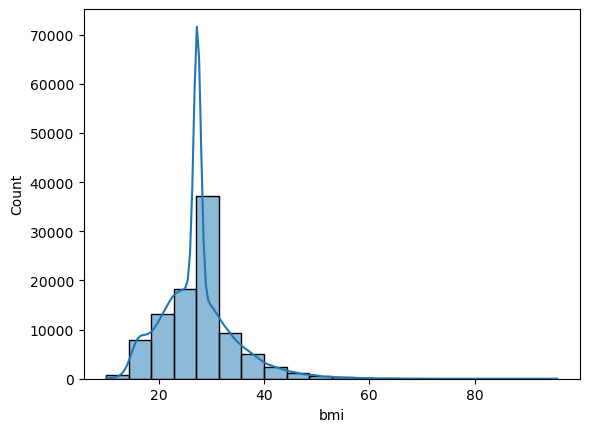

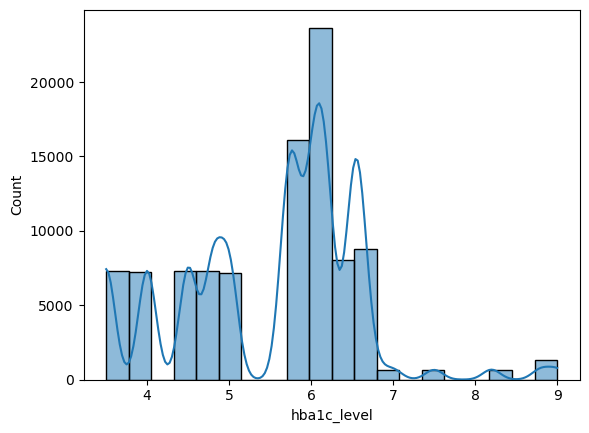

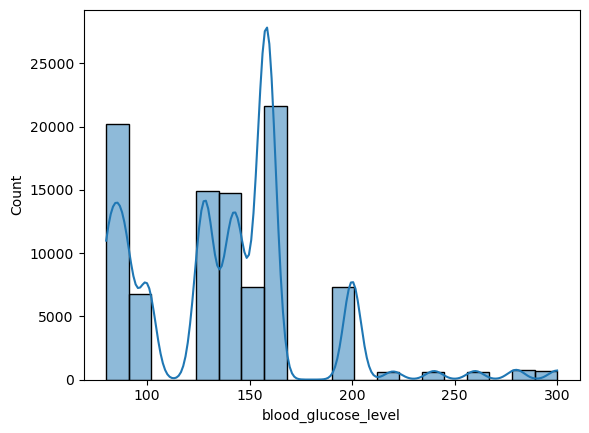

In [33]:
for i, col in enumerate(num_col):
    if col not in ['diabetes', 'hypertension', 'heart_disease']:
        plt.figure(i)
        sns.histplot(df[col], kde=True, bins=20)
        
df.describe()

### FINDINGS

-  
- 

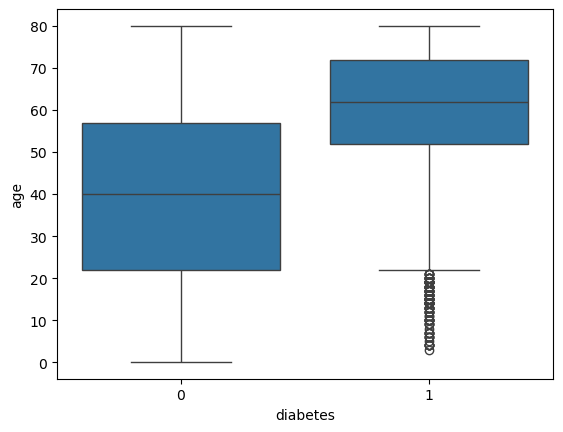

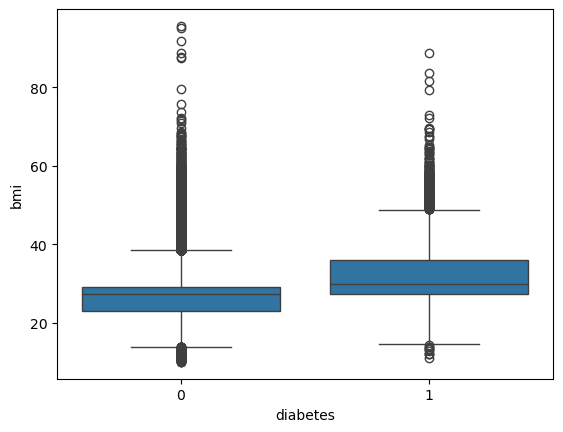

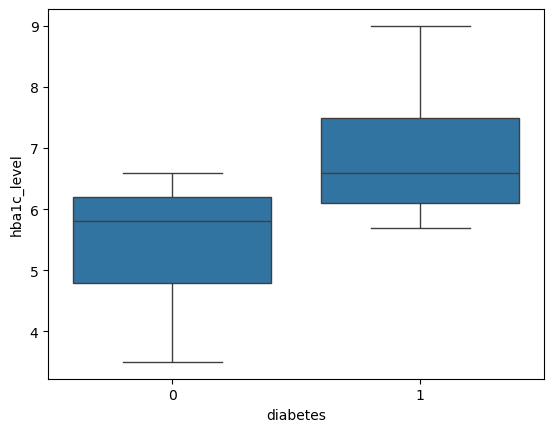

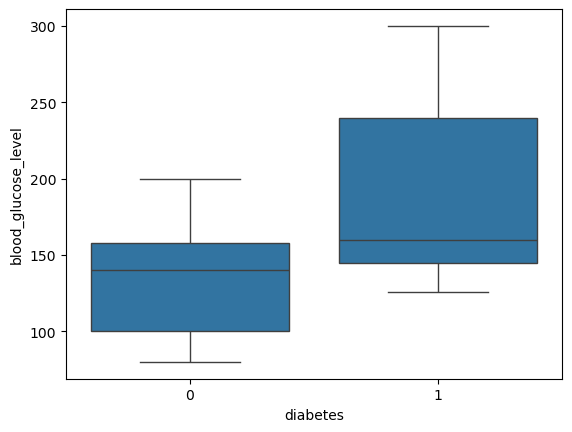

In [35]:
for i, col in enumerate(num_col):
    if col not in ['diabetes', 'hypertension', 'heart_disease']:
        plt.figure(i)
        sns.boxplot(x='diabetes', y=col, data=df)

### FINDINGS

-  
- 

##### TARGET VARIABLE ANALYSIS

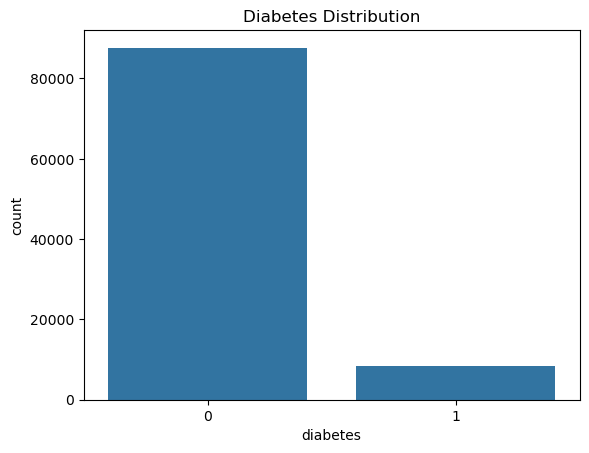

In [38]:
sns.countplot(x='diabetes', data=df)
plt.title('Diabetes Distribution')
plt.show()

In [39]:
df.diabetes.value_counts(normalize=True)

diabetes
0    0.91178
1    0.08822
Name: proportion, dtype: float64

### FINDINGS

- 
- 

### BIVARIATE DISTRIBUTION

<Axes: >

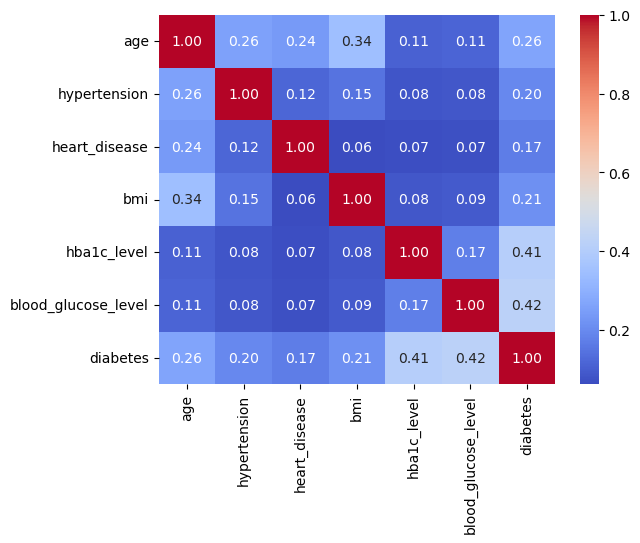

In [43]:
corr = df[num_col].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt='.2f')

### FINDINGS

-  
- 

### MODELLING

In [47]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score

#### LOGISTIC REGRESSION

In [51]:
from sklearn.linear_model import LogisticRegression

In [94]:
def linear_model_accuracy(data, col_removed=None, C=1.0):
    
    df_copy = data.copy()
    
    df_full_train, df_test = train_test_split(df_copy, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

    y_train = df_train['diabetes']
    y_val = df_val['diabetes']
    y_test = df_test['diabetes']
    y_full_train = df_full_train['diabetes']

    del df_train['diabetes']
    del df_val['diabetes']
    del df_test['diabetes']
    del df_full_train['diabetes']
    
    if col_removed!=None:
        del df_train[col_removed]
        del df_val[col_removed]
        del df_test[col_removed]
        del df_full_train[col_removed]

    df_train_emb = df_train.to_dict(orient="records")
    df_val_emb = df_val.to_dict(orient="records")

    df_full_train_emb = df_full_train.to_dict(orient="records")
    df_test_emb = df_test.to_dict(orient="records")

    dv = DictVectorizer(sparse=False)

    X_train = dv.fit_transform(df_train_emb)
    X_val = dv.transform(df_val_emb)

    X_full_train = dv.fit_transform(df_full_train_emb)
    X_test = dv.transform(df_test_emb)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)

    model.fit(X_train, y_train)
    pred_val = model.predict(X_val)

    lr_lst.append((col, C, roc_auc_score(y_val, pred_val)))

In [96]:
lr_lst = []

In [98]:
ind_cols = df.columns.tolist()
ind_cols.remove('diabetes')

In [100]:
for col in ind_cols+[None]:
    for c in [0.01, 0.1, 1, 10, 100]:
        linear_model_accuracy(data=df, col_removed=col, C = c)

In [101]:
# FIND THE MOST OPTIMAL VALUE OF C based on the ROC-AUC Score
col_to_remove, opt_c, auc_score = lr_lst[np.argmax(np.array(lr_lst)[:, 2])]
print("optimal C: %s" %opt_c)

df_copy = df.copy()

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

y_train = df_train['diabetes']
y_val = df_val['diabetes']
y_test = df_test['diabetes']
y_full_train = df_full_train['diabetes']

del df_train['diabetes']
del df_val['diabetes']
del df_test['diabetes']
del df_full_train['diabetes']

if col_to_remove!=None:
    del df_train[col_to_remove]
    del df_val[col_to_remove]
    del df_test[col_to_remove]
    del df_full_train[col_to_remove]    

df_train_emb = df_train.to_dict(orient="records")
df_val_emb = df_val.to_dict(orient="records")

df_full_train_emb = df_full_train.to_dict(orient="records")
df_test_emb = df_test.to_dict(orient="records")

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train_emb)
X_val = dv.transform(df_val_emb)

X_full_train = dv.fit_transform(df_full_train_emb)
X_test = dv.transform(df_test_emb)

model = LogisticRegression(solver='liblinear', C=opt_c, max_iter=1000, random_state=1)

model.fit(X_train, y_train)
pred_val = model.predict(X_val)

optimal C: 100


In [102]:
roc_auc_score(y_val, pred_val)

0.8193513275237414

In [103]:
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14045
           1       0.85      0.65      0.74      1339

    accuracy                           0.96     15384
   macro avg       0.91      0.82      0.86     15384
weighted avg       0.96      0.96      0.96     15384



In [104]:
# lr_test_pred = lr.predict(X_test)
# print(classification_report(y_test, lr_test_pred))
# print(roc_auc_score(y_test, lr_test_pred))

### ENSEMBLED DECISION TREES Algorithms

In [106]:
from sklearn.ensemble import RandomForestClassifier

In [107]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

y_train = df_train['diabetes']
y_val = df_val['diabetes']
y_test = df_test['diabetes']
y_full_train = df_full_train['diabetes']

del df_train['diabetes']
del df_val['diabetes']
del df_test['diabetes']
del df_full_train['diabetes']

df_train_emb = df_train.to_dict(orient="records")
df_val_emb = df_val.to_dict(orient="records")

df_full_train_emb = df_full_train.to_dict(orient="records")
df_test_emb = df_test.to_dict(orient="records")

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(df_train_emb)
X_val = dv.transform(df_val_emb)

X_full_train = dv.fit_transform(df_full_train_emb)
X_test = dv.transform(df_test_emb)

#### RANDOM FOREST

In [109]:
rf_lst = []

for depth in [10, 15, 20, 25]:
    for est in range(10, 210, 10):
        for n_split in [2, 5, 10]:
            rf = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=n_split, 
                                        random_state=1, n_jobs=-1)
            rf.fit(X_train, y_train)
            pred = rf.predict(X_val)
            eval_score = roc_auc_score(y_val, pred)
            rf_lst.append((depth, est, n_split, round(eval_score, 4)))

In [110]:
rf_lst[np.argmax(np.array(rf_lst)[:, 3])]

(20, 10, 2, 0.8446)

#### XGBOOST

In [112]:
import xgboost as xgb

In [113]:
features = dv.feature_names_
dtrain = xgb.DMatrix(X_train, y_train, feature_names=features)
dval = xgb.DMatrix(X_val, y_val, feature_names=features)

dtest = xgb.DMatrix(X_test, y_test, feature_names=features)
dfull_train = xgb.DMatrix(X_full_train, y_full_train, feature_names=features)

In [114]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [115]:
xgb_lst = []

for depth in [10, 15, 20, 25]:
    for eta in [0.01, 0.03, 0.1, 0.3, 1, 10]:
            xgb_params = {
                'eta': eta, 
                'max_depth': depth,
                'min_child_weight': 1,
                'early_stopping_rounds': 10,

                'objective': 'binary:logistic',
                'nthread': 8,

                'seed': 1,
                'verbosity': 1,
            }

            model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                              verbose_eval=5,
                              evals=watchlist)

            y_pred = model.predict(dval)
            predictions = [round(value) for value in y_pred]
            eval_score = roc_auc_score(y_val, predictions)
            
            xgb_lst.append((depth, eta, round(eval_score, 4)))

[0]	train-logloss:0.31604	val-logloss:0.31488
[5]	train-logloss:0.29581	val-logloss:0.29503
[10]	train-logloss:0.27887	val-logloss:0.27841
[15]	train-logloss:0.26423	val-logloss:0.26404
[20]	train-logloss:0.25132	val-logloss:0.25135
[25]	train-logloss:0.23976	val-logloss:0.24002
[30]	train-logloss:0.22931	val-logloss:0.22977
[35]	train-logloss:0.21979	val-logloss:0.22043
[40]	train-logloss:0.21104	val-logloss:0.21188
[45]	train-logloss:0.20299	val-logloss:0.20403
[50]	train-logloss:0.19556	val-logloss:0.19675
[55]	train-logloss:0.18866	val-logloss:0.19001
[60]	train-logloss:0.18225	val-logloss:0.18375
[65]	train-logloss:0.17628	val-logloss:0.17790
[70]	train-logloss:0.17071	val-logloss:0.17247
[75]	train-logloss:0.16549	val-logloss:0.16736
[80]	train-logloss:0.16060	val-logloss:0.16258
[85]	train-logloss:0.15602	val-logloss:0.15810
[90]	train-logloss:0.15172	val-logloss:0.15391
[95]	train-logloss:0.14770	val-logloss:0.14997
[100]	train-logloss:0.14390	val-logloss:0.14627
[105]	train-lo

[90]	train-logloss:0.04268	val-logloss:0.08674
[95]	train-logloss:0.04170	val-logloss:0.08707
[100]	train-logloss:0.04051	val-logloss:0.08740
[105]	train-logloss:0.03943	val-logloss:0.08773
[110]	train-logloss:0.03733	val-logloss:0.08814
[115]	train-logloss:0.03540	val-logloss:0.08887
[120]	train-logloss:0.03471	val-logloss:0.08923
[125]	train-logloss:0.03455	val-logloss:0.08933
[130]	train-logloss:0.03389	val-logloss:0.08969
[135]	train-logloss:0.03268	val-logloss:0.09040
[140]	train-logloss:0.03126	val-logloss:0.09087
[145]	train-logloss:0.03046	val-logloss:0.09149
[150]	train-logloss:0.02997	val-logloss:0.09178
[155]	train-logloss:0.02974	val-logloss:0.09189
[160]	train-logloss:0.02920	val-logloss:0.09222
[165]	train-logloss:0.02859	val-logloss:0.09259
[170]	train-logloss:0.02792	val-logloss:0.09295
[175]	train-logloss:0.02721	val-logloss:0.09329
[180]	train-logloss:0.02645	val-logloss:0.09378
[185]	train-logloss:0.02586	val-logloss:0.09405
[190]	train-logloss:0.02544	val-logloss:0.

[135]	train-logloss:0.10323	val-logloss:0.12757
[140]	train-logloss:0.10031	val-logloss:0.12541
[145]	train-logloss:0.09753	val-logloss:0.12336
[150]	train-logloss:0.09488	val-logloss:0.12143
[155]	train-logloss:0.09233	val-logloss:0.11963
[160]	train-logloss:0.08990	val-logloss:0.11794
[165]	train-logloss:0.08759	val-logloss:0.11632
[170]	train-logloss:0.08538	val-logloss:0.11479
[175]	train-logloss:0.08326	val-logloss:0.11334
[180]	train-logloss:0.08121	val-logloss:0.11195
[185]	train-logloss:0.07925	val-logloss:0.11066
[190]	train-logloss:0.07738	val-logloss:0.10936
[195]	train-logloss:0.07560	val-logloss:0.10820
[199]	train-logloss:0.07424	val-logloss:0.10733
[0]	train-logloss:0.30645	val-logloss:0.30599
[5]	train-logloss:0.25468	val-logloss:0.25775
[10]	train-logloss:0.21876	val-logloss:0.22516
[15]	train-logloss:0.19113	val-logloss:0.20047
[20]	train-logloss:0.16890	val-logloss:0.18110
[25]	train-logloss:0.15058	val-logloss:0.16547
[30]	train-logloss:0.13523	val-logloss:0.15272
[

[180]	train-logloss:0.00239	val-logloss:0.18179
[185]	train-logloss:0.00237	val-logloss:0.18252
[190]	train-logloss:0.00234	val-logloss:0.18286
[195]	train-logloss:0.00231	val-logloss:0.18374
[199]	train-logloss:0.00229	val-logloss:0.18392
[0]	train-logloss:0.39643	val-logloss:0.64614
[5]	train-logloss:3.93617	val-logloss:3.91588
[10]	train-logloss:3.93617	val-logloss:3.91588
[15]	train-logloss:3.93617	val-logloss:3.91588
[20]	train-logloss:3.93617	val-logloss:3.91588
[25]	train-logloss:3.93617	val-logloss:3.91588
[30]	train-logloss:3.93617	val-logloss:3.91588
[35]	train-logloss:3.93617	val-logloss:3.91588
[40]	train-logloss:3.93617	val-logloss:3.91588
[45]	train-logloss:3.93617	val-logloss:3.91588
[50]	train-logloss:3.93617	val-logloss:3.91588
[55]	train-logloss:3.93617	val-logloss:3.91588
[60]	train-logloss:3.93617	val-logloss:3.91588
[65]	train-logloss:3.93617	val-logloss:3.91588
[70]	train-logloss:3.93617	val-logloss:3.91588
[75]	train-logloss:3.93617	val-logloss:3.91588
[80]	train

[20]	train-logloss:0.02505	val-logloss:0.09647
[25]	train-logloss:0.02204	val-logloss:0.09822
[30]	train-logloss:0.01916	val-logloss:0.10016
[35]	train-logloss:0.01696	val-logloss:0.10256
[40]	train-logloss:0.01506	val-logloss:0.10523
[45]	train-logloss:0.01345	val-logloss:0.10773
[50]	train-logloss:0.01252	val-logloss:0.10928
[55]	train-logloss:0.01156	val-logloss:0.11170
[60]	train-logloss:0.01073	val-logloss:0.11314
[65]	train-logloss:0.01002	val-logloss:0.11486
[70]	train-logloss:0.00949	val-logloss:0.11651
[75]	train-logloss:0.00917	val-logloss:0.11750
[80]	train-logloss:0.00886	val-logloss:0.11863
[85]	train-logloss:0.00836	val-logloss:0.12008
[90]	train-logloss:0.00798	val-logloss:0.12151
[95]	train-logloss:0.00766	val-logloss:0.12259
[100]	train-logloss:0.00736	val-logloss:0.12368
[105]	train-logloss:0.00706	val-logloss:0.12491
[110]	train-logloss:0.00682	val-logloss:0.12583
[115]	train-logloss:0.00664	val-logloss:0.12675
[120]	train-logloss:0.00647	val-logloss:0.12757
[125]	tr

In [116]:
xgb_lst[np.argmax(np.array(xgb_lst)[:, 2])]

(10, 1, 0.8566)

#### ENSEMBLED

In [118]:
est, depth, n_split, score = rf_lst[np.argmax(np.array(rf_lst)[:, 3])]

rf = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=n_split, 
                            random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

In [119]:
print(classification_report(y_val, rf_pred))
print(roc_auc_score(y_val, rf_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14045
           1       1.00      0.67      0.80      1339

    accuracy                           0.97     15384
   macro avg       0.98      0.83      0.89     15384
weighted avg       0.97      0.97      0.97     15384

0.8345780433159073


[('hba1c_level', 0.4443743138895324),
 ('age', 0.44143420249692433),
 ('gender', 0.04657776090153695),
 ('hypertension', 0.026798250576884338),
 ('blood_glucose_level', 0.011783025144382609),
 ('heart_disease', 0.0012060254463524226),
 ('smoking_history', 0.0007132301700220322),
 ('bmi', 3.299823562781928e-07)]

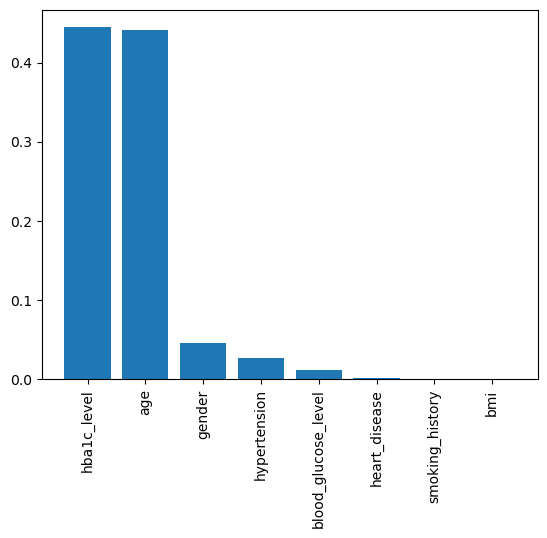

In [213]:
feature_imp = list(zip(df_full_train.columns, rf.feature_importances_))
feature_imp = sorted(feature_imp, key=lambda x:x[1], reverse=True)
plt.bar(*zip(*feature_imp))
plt.xticks(rotation=90)
plt.show()

In [120]:
depth, eta, score = xgb_lst[np.argmax(np.array(xgb_lst)[:, 2])]

xgb_params = {
    'eta': eta, 
    'max_depth': depth,
    'min_child_weight': 1,
    'early_stopping_rounds': 10,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

y_pred = xgb_model.predict(dval)
xgb_pred = [round(value) for value in y_pred]
eval_score = roc_auc_score(y_val, xgb_pred)

[0]	train-logloss:0.12038	val-logloss:0.12490
[5]	train-logloss:0.07147	val-logloss:0.08716
[10]	train-logloss:0.05398	val-logloss:0.09673
[15]	train-logloss:0.04587	val-logloss:0.10197
[20]	train-logloss:0.03537	val-logloss:0.10764
[25]	train-logloss:0.02868	val-logloss:0.11475
[30]	train-logloss:0.02336	val-logloss:0.11953
[35]	train-logloss:0.01961	val-logloss:0.12292
[40]	train-logloss:0.01658	val-logloss:0.12625
[45]	train-logloss:0.01450	val-logloss:0.12951
[50]	train-logloss:0.01324	val-logloss:0.13225
[55]	train-logloss:0.01181	val-logloss:0.13489
[60]	train-logloss:0.01087	val-logloss:0.13692
[65]	train-logloss:0.00988	val-logloss:0.14009
[70]	train-logloss:0.00921	val-logloss:0.14268
[75]	train-logloss:0.00862	val-logloss:0.14462
[80]	train-logloss:0.00790	val-logloss:0.14746
[85]	train-logloss:0.00731	val-logloss:0.14972
[90]	train-logloss:0.00681	val-logloss:0.15219
[95]	train-logloss:0.00644	val-logloss:0.15355
[100]	train-logloss:0.00625	val-logloss:0.15464
[105]	train-lo

In [121]:
print(classification_report(y_val, xgb_pred))
print(eval_score)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14045
           1       0.82      0.73      0.77      1339

    accuracy                           0.96     15384
   macro avg       0.90      0.86      0.88     15384
weighted avg       0.96      0.96      0.96     15384

0.8566372996643935


In [122]:
val_pred_df = pd.DataFrame({'LOGISTIC':pred_val, 'RF':rf_pred, 'XGB':xgb_pred})
val_pred_df['Ensembled'] = val_pred_df.mode(axis=1)

In [123]:
print(roc_auc_score(y_val, val_pred_df['Ensembled']))
print(classification_report(y_val, val_pred_df['Ensembled']))

0.8399648680718197
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14045
           1       0.97      0.68      0.80      1339

    accuracy                           0.97     15384
   macro avg       0.97      0.84      0.89     15384
weighted avg       0.97      0.97      0.97     15384



In [124]:
# test_pred_df = pd.DataFrame({'LOGISTIC':lr_test_pred, 'RF':rf_test_pred, 'XGB':xgb_test_pred})
# test_pred_df['Ensembled'] = test_pred_df.mode(axis=1)

# print(roc_auc_score(y_test, test_pred_df['Ensembled']))
# print(classification_report(y_test, test_pred_df['Ensembled']))

#### TESTING

In [126]:
model = LogisticRegression(solver='liblinear', C=100, max_iter=1000, random_state=1)
model.fit(X_full_train, y_full_train)

lr_test_pred = model.predict(X_test)
print(classification_report(y_test, lr_test_pred))
print(roc_auc_score(y_test, lr_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17489
           1       0.86      0.63      0.73      1741

    accuracy                           0.96     19230
   macro avg       0.91      0.81      0.85     19230
weighted avg       0.95      0.96      0.95     19230

0.8109371381679841


In [127]:
rf = RandomForestClassifier(n_estimators=est, max_depth=depth, min_samples_split=n_split, 
                            random_state=1, n_jobs=-1)
rf.fit(X_full_train, y_full_train)

rf_test_pred = rf.predict(X_test)
print(classification_report(y_test, rf_test_pred))
print(roc_auc_score(y_test, rf_test_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17489
           1       1.00      0.65      0.79      1741

    accuracy                           0.97     19230
   macro avg       0.98      0.83      0.89     19230
weighted avg       0.97      0.97      0.97     19230

0.825617720684954


In [128]:
xgb_model = xgb.train(xgb_params, dfull_train, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

y_pred = xgb_model.predict(dtest)
xgb_test_pred = [round(value) for value in y_pred]

print(classification_report(y_test, xgb_test_pred))
print(roc_auc_score(y_test, xgb_test_pred))

[0]	train-logloss:0.12093	val-logloss:0.12061
[5]	train-logloss:0.07342	val-logloss:0.07089
[10]	train-logloss:0.06193	val-logloss:0.05931
[15]	train-logloss:0.05041	val-logloss:0.04918
[20]	train-logloss:0.03846	val-logloss:0.03766
[25]	train-logloss:0.03101	val-logloss:0.03069
[30]	train-logloss:0.02614	val-logloss:0.02575
[35]	train-logloss:0.02297	val-logloss:0.02222
[40]	train-logloss:0.01922	val-logloss:0.01928
[45]	train-logloss:0.01686	val-logloss:0.01664
[50]	train-logloss:0.01473	val-logloss:0.01461
[55]	train-logloss:0.01360	val-logloss:0.01342
[60]	train-logloss:0.01265	val-logloss:0.01247
[65]	train-logloss:0.01145	val-logloss:0.01131
[70]	train-logloss:0.01067	val-logloss:0.01063
[75]	train-logloss:0.00985	val-logloss:0.00989
[80]	train-logloss:0.00924	val-logloss:0.00926
[85]	train-logloss:0.00874	val-logloss:0.00889
[90]	train-logloss:0.00826	val-logloss:0.00848
[95]	train-logloss:0.00763	val-logloss:0.00789
[100]	train-logloss:0.00728	val-logloss:0.00764
[105]	train-lo

In [129]:
test_pred_df = pd.DataFrame({'LOGISTIC':lr_test_pred, 'RF':rf_test_pred, 'XGB':xgb_test_pred})
test_pred_df['Ensembled'] = test_pred_df.mode(axis=1)

print(roc_auc_score(y_test, test_pred_df['Ensembled']))
print(classification_report(y_test, test_pred_df['Ensembled']))

0.8356447175510239
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17489
           1       0.97      0.67      0.80      1741

    accuracy                           0.97     19230
   macro avg       0.97      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



In [157]:
df_test.iloc[0].to_dict()

{'gender': 'Male',
 'age': 33.0,
 'hypertension': 0,
 'heart_disease': 0,
 'smoking_history': 'former',
 'bmi': 35.81,
 'hba1c_level': 5.8,
 'blood_glucose_level': 140}

In [181]:
import joblib

In [191]:
with open("../models/dv.bin", "wb") as file_in:
    pickle.dump(dv, file_in)
    
with open("../models/lr.bin", "wb") as file_in:
    pickle.dump(model, file_in)

with open("../models/rf.bin", "wb") as file_in:
    pickle.dump(rf, file_in)

with open("../models/xgb.bin", "wb") as file_in:
    pickle.dump(xgb_model, file_in)